In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit
import pymc3 as pm
import theano.tensor as tt
#import pymc as pm
from scipy.integrate import odeint
from multiprocessing import Pool

%matplotlib inline

# Load values

In [6]:
online = True

if online:
    COVID_CONFIRMED_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    COVID_DEATHS_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
    COVID_RECOVERED_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
else:
    COVID_CONFIRMED_URL = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    COVID_DEATHS_URL = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
    COVID_RECOVERED_URL = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
    


covid_confirmed = pd.read_csv(COVID_CONFIRMED_URL)
covid_deaths = pd.read_csv(COVID_DEATHS_URL)
covid_recovered = pd.read_csv(COVID_RECOVERED_URL)

covid_confirmed.rename(columns={'Country/Region':'Country'}, inplace=True)
covid_deaths.rename(columns={'Country/Region':'Country'}, inplace=True)
covid_recovered.rename(columns={'Country/Region':'Country'}, inplace=True)
covid_confirmed.rename(columns={'Province/State':'State'}, inplace=True)
covid_deaths.rename(columns={'Province/State':'State'}, inplace=True)
covid_recovered.rename(columns={'Province/State':'State'}, inplace=True)


covid_confirmed.head()

,State,Country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,174,237,273,281,299,349,367,423,444,484
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,243,259,277,304,333,361,377,383,400,409
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,716,847,986,1171,1251,1320,1423,1468,1572,1666
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,376,390,428,439,466,501,525,545,564,583
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,7,8,8,8,10,14,16,17,19,19


In [7]:
Country = 'Russia'
population = {"Russia" : 146745098, "Italy" : 60317000, "China" : 1404328000}

data_Russia_confirmed = covid_confirmed[covid_confirmed.Country == Country].values[0, 4:].astype(int)

data = np.empty((3, data_Russia_confirmed.shape[0]), dtype=np.int64)
data[0] = data_Russia_confirmed

data[1] = covid_deaths   [covid_deaths.Country    == Country].values[0, 4:].astype(int)
data[2] = covid_recovered[covid_recovered.Country == Country].values[0, 4:].astype(int)

data_normed = data.astype(np.float64) / population[Country]
data_normed_only_conf = data_normed[0] - data_normed[1] - data_normed[2]

true_vals = data_normed[0][data[0] >= 3]

In [ ]:
plt.plot(data.T);
plt.figure()
plt.plot(data_normed_only_conf);

# SEIR ans SIR-X model

In [20]:
def Runge_Kutta(rhs, x0, N, h=0.25, type_ret='tt'):
    # N is number of days
    # h is time step
    res = [x0]
    x = x0
    h2 = h/2
    for i in range(1, int(N/h)): # 1 as we already have x0
        k1 = rhs(x)
        k2 = rhs(x + h2*k1)
        k3 = rhs(x + h2*k2)
        k4 = rhs(x + h*k3)
        
        x = x + h/6*(k1 + 2*k2 + 2*k3 + k4)
        if abs(i*h - np.round(i*h)) < 1e-6: 
            res.append(x)

    if    type_ret=='tt':
        return tt.stack(res)
    elif  type_ret=='tf':
        return tf.stack(res)
    else: # type_ret=='np':
        return np.array(res)



@jit
def base_seir_model(init_vals, dt, N, params):
    res = np.empty((N, 4), dtype=np.float64)
    S = res[:, 0]
    E = res[:, 1]
    I = res[:, 2]
    R = res[:, 3]
    S[0], E[0], I[0], R[0] = init_vals
    alpha, beta, gamma = params
    for i in range(1, N):
        S[i] = S[i-1] - (beta*S[i-1]*I[i-1])*dt
        E[i] = E[i-1] + (beta*S[i-1]*I[i-1] - alpha*E[i-1])*dt
        I[i] = I[i-1] + (alpha*E[i-1] - gamma*I[i-1])*dt
        R[i] = R[i-1] + (gamma*I[i-1])*dt

    #print(I)
    return res


def seir_rhs(y, t, alpha, beta, gamma):
    S, E, I, R = y
    return [-beta*S*I, beta*S*I - alpha*E, alpha*E - gamma*I, gamma*I]

def base_seir_model_odeint(init_vals, dt, N, params):
    t_max = N*dt
    t = np.linspace(0, t_max - 1, N)
    sol = odeint(seir_rhs, init_vals, t, args=params)
    #return sol[::int(1/dt)]
    return sol

#@jit
def sirx_rhs_old(x, t, alpha, beta, k0, k):
    S, I, X, R = x
    dsdt = -alpha*S*I - k0*S
    didt = (alpha*S - beta - (k0 + k))*I
    dxdt = (k0 + k)*I
    dRdt = k0*S + beta*I
    return np.array([dsdt, didt, dxdt, dRdt])

def sirx_rhs(x, t, alpha, beta, k0, k, type_ret='tt'):
    S = x[0]
    I = x[1]
    X = x[2]
    R = x[3]
    dsdt = -alpha*S*I - k0*S
    didt = (alpha*S - beta - (k0 + k))*I
    dxdt = (k0 + k)*I
    dRdt = k0*S + beta*I
    if    type_ret=='tt':
        return tt.stack([dsdt, didt, dxdt, dRdt])
    elif  type_ret=='tf':
        return tf.stack([dsdt, didt, dxdt, dRdt])
    else: # type_ret=='np':
        return np.array([dsdt, didt, dxdt, dRdt])



def base_sirx_model_rhs(x, params):
    alpha, beta, k0, k = params
    S, I, X, R = x
    dsdt = -alpha*S*I - k0*S
    didt = alpha*S*I - beta*I - k0*I - k*I
    dxdt = (k0+k)*I
    dRdt = k0*S + beta*I
    return np.array([dsdt, didt, dxdt, dRdt])

#@jit
def base_sirx_model_odeint(init_vals, dt, N, params):
    t_max = N*dt
    t = np.linspace(0, t_max - 1, N)
    params = tuple(list(params) + ['np'])
    sol = odeint(sirx_rhs, init_vals, t, args=params)
    #sol[np.isnan(sol)] = 1e20
    #sol[np.isinf(sol)] = 1e20
    return sol

def base_sirx_model_RK(init_vals, N, params, type_ret='np'):
    
    alpha_MC, beta_MC, k0_MC, k_MC = params
    func = lambda x: sirx_rhs(x, None, alpha_MC, beta_MC, k0_MC, k_MC, type_ret=type_ret)
    sol = Runge_Kutta(func, init_vals, N, type_ret='np')
    
    return sol

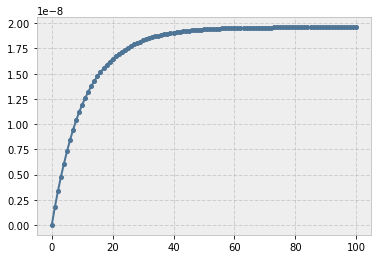

In [21]:
# Test
t_max = 10
dt = .1
N = int(t_max / dt) + 1
t = np.linspace(0, t_max, N)

Nn = 1000000
init_vals = 1 - 1/Nn, 1/Nn, 0, 0
alpha = 0.02
beta = 1
gamma = 1
params = alpha, beta, gamma
# Run simulation
results = base_seir_model_odeint(init_vals, dt, N, params)

#plt.plot(t, results[:, 2]);
plt.plot(results[:, 2]);

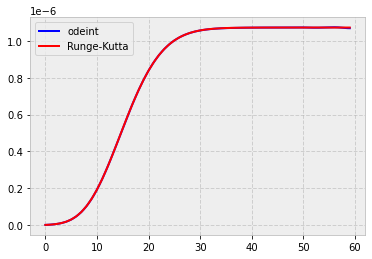

In [22]:
# Test SIRX & RK
t_max = 60
dt = .1
N = int(t_max / dt)
t = np.linspace(0, t_max - 1, N)

x0 = np.array([1.0, 1e-8, 0.0, 0.0])
beta = 0.38 #d^{-1}
R0 = 3.07
alpha = R0*beta
k0 = 6e-2
k = 5e-2

params = alpha, beta, k0, k

results = base_sirx_model_odeint(x0, dt, N, params)
results_RK = base_sirx_model_RK(x0, t_max, params)

letter = 2
plt.plot(t, results[:, letter], 'b-', label='odeint');
plt.plot(results_RK[:, letter], 'r-', label='Runge-Kutta');
plt.legend();

# Apply MCMC (from pyMC3)

In [23]:
# SIRX
model_sixr = pm.Model()

with model_sixr:

    alpha_MC = pm.Uniform("alpha_MC", 1e-5, 2)
    beta_MC  = pm.Uniform("beta_MC", 1e-5, 2)
    k0_MC    = pm.Uniform("k0_MC", 1e-7, 1)
    k_MC     = pm.Uniform("k_MC", 1e-7, 1)
    #I0_MC    = pm.Exponential("I0_MC", 1e-6)
    I0_MC    = pm.Uniform("I0_MC", 0, 1)
    
    
    
    num_days = len(true_vals)
    init_vals = tt.stack([1.0 - (I0_MC + true_vals[0]), I0_MC, true_vals[0], 0])
    
    func = lambda x: sirx_rhs(x, None, alpha_MC, beta_MC, k0_MC, k_MC)
    sol = Runge_Kutta(func, init_vals, num_days)[:, 2]
    # Flatten!!!
    obs = tt.reshape(sol, [-1])

    # infected (we know them)
    I_MC = pm.Normal("I_MC", obs, 1e-8, observed=true_vals)




WARNING (theano.gof.compilelock): Overriding existing lock by dead process '29549' (I am process '31267')


In [45]:
num_treads = 7
pool = Pool(num_treads)

def thread_run(i):
    with model_sixr:

        step = pm.Metropolis()
        #step = pm.NUTS()
        start = pm.find_MAP()
        print(start)
        trace = pm.sample(50000, step=step, start=start, chain=i)
        return trace


In [ ]:
tr = pool.map(thread_run, range(num_treads))

In [ ]:
trace = pm.merge_trace(tr)

In [ ]:
burned_trace = trace[500::2]

alpha_samples = burned_trace['alpha_MC']
beta_samples  = burned_trace['beta_MC']
k0_samples    = burned_trace['k0_MC']
k_samples     = burned_trace['k_MC']
I0_samples    = burned_trace['I0_MC']



plt.figure(figsize=(12.5, 6))

# histogram of the samples:
plt.subplot(311)
plt.title(r"Posterior distributions of the variables $\alpha, \beta, k_0$")
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#7A68A6", density=True)
plt.legend()

plt.subplot(312)
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#A60628", density=True)
plt.legend();

plt.subplot(313)
plt.hist(k0_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $k_0$", color="#467821", density=True)
plt.legend();


plt.figure(figsize=(12.5, 6))

plt.subplot(211)
plt.title(r"Posterior distributions of the variables $k, I_0$")
plt.hist(k_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $k$", color="#7A68A6", density=True)
plt.legend()

plt.subplot(212)
plt.hist(I0_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $I_0$", color="#A60628", density=True)
plt.legend();


# Apply MCMC (from pyMC2)

## SIR-X

In [274]:
# SIRX

alpha_MC = pm.Uniform("alpha_MC", 1e-5, 2)
beta_MC  = pm.Uniform("beta_MC", 1e-5, 2)
k0_MC = pm.Uniform("k0_MC", 1e-7, 1)
k_MC    = pm.Uniform("k_MC", 1e-7, 1)



#alpha_MC = pm.Normal("alpha_MC", 1.1, 0.2)
#beta_MC  = pm.Normal("beta_MC", 0.38, 0.05)
#k0_MC    = pm.Normal("k0_MC", 0.06, 0.01)
#k_MC     = pm.Normal("k_MC", 0.05, 0.01)
I0_MC    = pm.Exponential("I0_MC", 1e-6)



#true_vals = data_normed[0]
true_vals = data_normed[0][data[0] >= 3]


vals = []

@pm.deterministic
def obs(alpha_MC, beta_MC, k0_MC, k_MC, I0_MC, cf = 1, N = len(true_cases), type_ret=2):
        # N is number of points (days)
        #global vals
        dt = 1.0/cf
        num = (N-1)*cf
        res = base_sirx_model_odeint((1.0 - (I0_MC + true_cases[0]), I0_MC, true_cases[0], 0.0), dt, num, (alpha_MC, beta_MC, k0_MC, k_MC))
        rr = res.T[type_ret][::cf]
        #print(rr)
        #vals.append(rr)
        return rr
    
# infected (we know them)
#I_MC = pm.Exponential("I_MC", obs, observed=True, value=data_normed[0])
I_MC = pm.Normal("I_MC", obs, 1e-8, observed=True, value=true_vals)

mcmc = pm.MCMC([alpha_MC, beta_MC, k0_MC, k_MC, I0_MC, I_MC])
#mcmc.sample(100000, 10000, 100)
#mcmc.sample(10)
#mcmc.sample(1000, 100, 10)
mcmc.sample(1500000, 5000, 10)

 [-----------------100%-----------------] 1500000 of 1500000 complete in 10564.2 sec               1%                  ] 25637 of 1500000 complete in 184.1 sec[                  2%                  ] 37406 of 1500000 complete in 265.8 sec[---               8%                  ] 131079 of 1500000 complete in 904.7 sec[---               8%                  ] 133904 of 1500000 complete in 923.9 sec[---               9%                  ] 144110 of 1500000 complete in 993.5 sec[-----            13%                  ] 200454 of 1500000 complete in 1377.9 sec[------           17%                  ] 266082 of 1500000 complete in 1825.7 sec[------           17%                  ] 269290 of 1500000 complete in 1847.9 sec[----------       26%                  ] 400706 of 1500000 complete in 2751.6 sec[-----------      30%                  ] 455655 of 1500000 complete in 3129.9 sec[-----------      31%                  ] 465491 of 1500000 complete in 3198.5 sec[-------------    34%               

In [254]:
map = pm.MAP([alpha_MC, beta_MC, k0_MC, k_MC, I0_MC, I_MC])

In [264]:
for i in map.variables:
    print(i)
    

alpha_MC
k0_MC
I0_MC
I_MC
k_MC
beta_MC


In [265]:
map

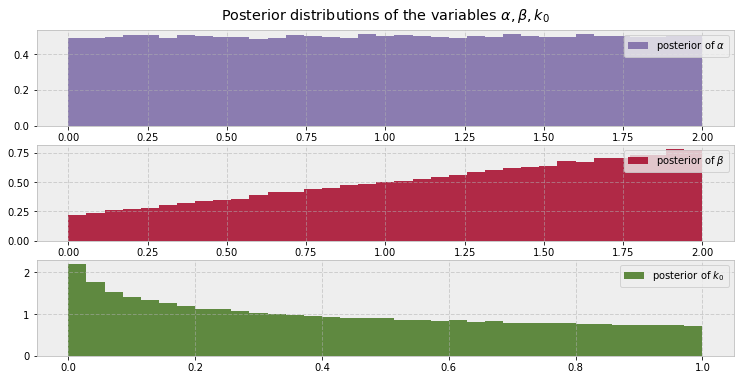

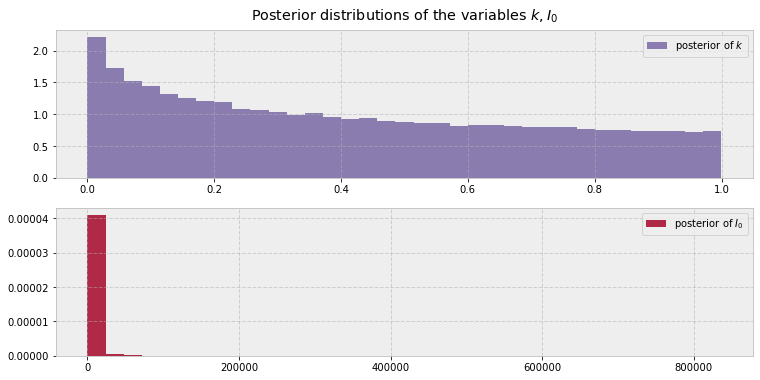

In [276]:
alpha_samples = mcmc.trace('alpha_MC')[:]
beta_samples = mcmc.trace('beta_MC')[:]
k0_samples = mcmc.trace('k0_MC')[:]
k_samples = mcmc.trace('k_MC')[:]
I0_samples = mcmc.trace('I0_MC')[:]



plt.figure(figsize=(12.5, 6))

# histogram of the samples:
plt.subplot(311)
plt.title(r"Posterior distributions of the variables $\alpha, \beta, k_0$")
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#7A68A6", density=True)
plt.legend()

plt.subplot(312)
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#A60628", density=True)
plt.legend();

plt.subplot(313)
plt.hist(k0_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $k_0$", color="#467821", density=True)
plt.legend();


plt.figure(figsize=(12.5, 6))

plt.subplot(211)
plt.title(r"Posterior distributions of the variables $k, I_0$")
plt.hist(k_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $k$", color="#7A68A6", density=True)
plt.legend()

plt.subplot(212)
plt.hist(I0_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $I_0$", color="#A60628", density=True)
plt.legend();


## SEIR

In [233]:
# SEIR

"""
alpha_MC = pm.Exponential("alpha_MC", 1./0.2)
beta_MC  = pm.Exponential("beta_MC", 1./0.5)
gamma_MC = pm.Exponential("gamma_MC", 1./0.4)
Nn_MC    = pm.Exponential("Nn_MC", 1./10000)
"""


"""
alpha_MC = pm.Uniform("alpha_MC", 0.0002, 2)
beta_MC  = pm.Uniform("beta_MC", 0.001, 2)
gamma_MC = pm.Uniform("gamma_MC", 0.001, 2)
Nn_MC    = pm.Uniform("Nn_MC", 1000, 1e6)
"""

alpha_MC = pm.Normal("alpha_MC", 5, 2)
beta_MC  = pm.Normal("beta_MC", 5, 2)
gamma_MC = pm.Normal("gamma_MC", 5, 2)
Nn_MC    = pm.Exponential("Nn_MC", 1./10000)



vals = []

@pm.deterministic
def obs(alpha_MC=alpha_MC, beta_MC=beta_MC, gamma_MC=gamma_MC, Nn_MC=Nn_MC):
        global vals
        cf = 4
        dt = 1.0/cf
        N = len(data_normed_only_conf)
        num = (N-1)*cf + 1
#        res = base_seir_model_odeint((1 - 1/Nn_MC, 1/Nn_MC, 0, 0), dt, num, (alpha_MC, beta_MC, gamma_MC))
        res = base_seir_model((1 - 1/Nn_MC, 1/Nn_MC, 0, 0), dt, num, (alpha_MC, beta_MC, gamma_MC))
        rr = res.T[2][::cf]
        #print(rr)
        vals.append(rr)
        return rr
    
# infected (we know them)
#I_MC = pm.Exponential("I_MC", obs, observed=True, value=data_normed[0])
I_MC = pm.Normal("I_MC", obs, [1e-8]*len(data_normed_only_conf), observed=True, value=data_normed_only_conf)

#model = pm.Model([alpha_MC, beta_MC, gamma_MC, Nn_MC, I_MC])
#mcmc = pm.MCMC(model)
mcmc = pm.MCMC([alpha_MC, beta_MC, gamma_MC, Nn_MC, I_MC])
mcmc.sample(100000, 10000, 100)
#mcmc.sample(10)
#mcmc.sample(1000, 100, 10)
#mcmc.sample(10000, 1000, 10)


 [-----------------100%-----------------] 100000 of 100000 complete in 23.6 sec

In [237]:
alpha_samples = mcmc.trace('alpha_MC')[:]
beta_samples = mcmc.trace('beta_MC')[:]
gamma_samples = mcmc.trace('gamma_MC')[:]


plt.figure(figsize=(12.5, 6))

# histogram of the samples:
plt.subplot(311)
plt.title(r"Posterior distributions of the variables $\alpha, \beta, \gamma$")
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#7A68A6", density=True)
plt.legend()

plt.subplot(312)
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#A60628", density=True)
plt.legend();

plt.subplot(313)
plt.hist(gamma_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\gamma$", color="#467821", density=True)
plt.legend();


KeyError: 'gamma_MC'

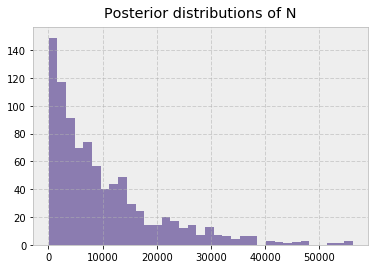

In [134]:
Nn_samples = mcmc.trace('Nn_MC')[:]
plt.title(r"Posterior distributions of N")
plt.hist(Nn_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#7A68A6");


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in double_scalars
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in double_scalars


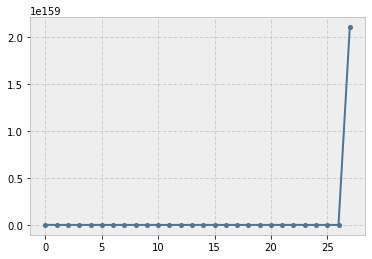

In [243]:
params = 2.5, 5, 4.8, -23, 9000
def obs(alpha_MC=alpha_MC, beta_MC=beta_MC, k0_MC=k0_MC, k_MC=k_MC, I0_MC=I0_MC):
        #global vals
        cf = 4
        dt = 1.0/cf
        N = len(data_normed_only_conf)
        num = (N-1)*cf + 1
        res = base_sirx_model_odeint((1, I0_MC, 0, 0), dt, num, (alpha_MC, beta_MC, k0_MC, k_MC))
        rr = res.T[1][::cf]
        #print(rr)
        #vals.append(rr)
        return rr
plt.plot(obs(*params))